In [25]:
import pandas as pd

# Read the CSV file into the DataFrame
df = pd.read_csv(r'D:\shared_git\MaestriaThesis\results\pp03\eeglabStudy\output_mat.csv')

# Rename the first four columns
new_column_names = ['channels', 'ID', 'Type', 'Epoch']
df.rename(columns=dict(zip(df.columns[:4], new_column_names)), inplace=True)

filtered_class_labels = df[df['channels'] == 5]
filtered_class_labels = filtered_class_labels.drop(columns=['ID'])
filtered_class_labels = filtered_class_labels.drop(columns=['channels', 'Epoch'])
filtered_class_labels = filtered_class_labels.reset_index(drop=True)

# Extract the next 1000 columns as an array
data_array = filtered_class_labels.iloc[:, 4:].values
class_labels = filtered_class_labels.iloc[:,0]

print(class_labels)


0        1
1        1
2        1
3        1
4        1
        ..
6919    12
6920    12
6921    12
6922    12
6923    12
Name: Type, Length: 6924, dtype: int64


In [26]:
mods = class_labels.copy() 
mod = ['Air', 'Vib', 'Car']
mods[(4 >= class_labels)] = mod[0]
mods[(5 <= class_labels) & (8 >= class_labels)] = mod[1]
mods[(9 <= class_labels) & (12 <= class_labels)] = mod[2]

print(mods.head(7000)) 
class_labels = (class_labels - 1) % 4 + 1 


0       Air
1       Air
2       Air
3       Air
4       Air
       ... 
6919    Car
6920    Car
6921    Car
6922    Car
6923    Car
Name: Type, Length: 6924, dtype: object


In [27]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, resample

lowcut = 2.0  
highcut = 30.0  
fs_original = 250.0  
fs_downsampled = 60 

nyquist = 0.5 * fs_original
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

filtered_data_array = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=1, arr=data_array)

downsample_factor = int(fs_original / fs_downsampled)
downsampled_data_array = resample(filtered_data_array, len(filtered_data_array[0]) // downsample_factor, axis=1)

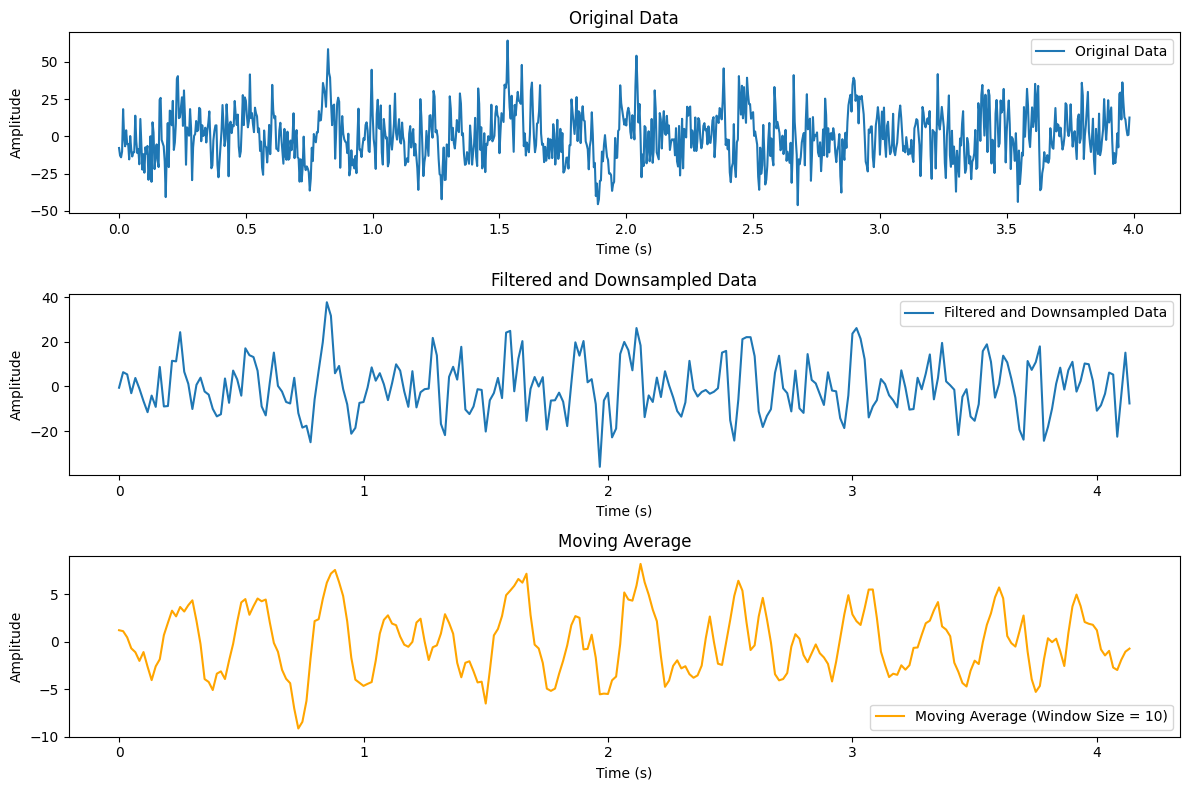

In [28]:
import pandas as pdc
import numpy as np
from scipy.signal import butter, filtfilt, resample
import matplotlib.pyplot as plt

row_index = 0
original_row = data_array[row_index, :]
filtered_row = filtered_data_array[row_index, :]
downsampled_row = downsampled_data_array[row_index, :]

window_size = 10
moving_average_row = np.convolve(downsampled_row, np.ones(window_size)/window_size, mode='same')

time_original = np.arange(0, len(original_row)) / fs_original

time_downsampled = np.arange(0, len(downsampled_row)) / fs_downsampled

time_moving_average = np.arange(0, len(moving_average_row)) / fs_downsampled

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time_original, original_row, label='Original Data')
plt.title('Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_downsampled, downsampled_row, label='Filtered and Downsampled Data')
plt.title('Filtered and Downsampled Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_moving_average, moving_average_row, label=f'Moving Average (Window Size = {window_size})', color='orange')
plt.title('Moving Average')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Create a DataFrame with the downsampled data and class labels
combined_df = pd.concat([mods, pd.DataFrame(downsampled_data_array)], axis=1)

print(combined_df)

     Type          0          1          2           3          4          5  \
0     Air  -0.566684   6.400093   5.404850   -3.019546   3.798764  -0.994137   
1     Air  13.892585  31.520809  24.239059   26.591599  33.035642   8.424307   
2     Air   7.090871  16.176860 -24.589857  -42.406479 -74.690366 -34.691013   
3     Air  -9.040403   4.891928  12.415366   15.203384  -1.273530 -20.047200   
4     Air   0.995053  -0.097663  -8.601772   -6.389372  -6.386539  -3.125807   
...   ...        ...        ...        ...         ...        ...        ...   
6919  Car  -0.857070  43.984024  66.761900   46.012060  -3.372146 -16.695539   
6920  Car  -6.617663  -2.786899   5.452942   -1.773076   1.619227 -18.082221   
6921  Car  -2.911770  12.729326  21.705496   15.485513  15.352719  22.685510   
6922  Car   9.413103  45.139768  64.916749  105.739301  65.552223 -12.037779   
6923  Car   3.940385   6.779815  19.287770   -4.640220 -11.244363  12.602171   

              6          7          8  

In [30]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Select features (X) and target variable (y)
X = downsampled_data_array  # Assuming the downsampled data starts from the 5th column
y = class_labels.values  # Assuming 'channels' is the target variable

y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=12)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 25.42%


In [32]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute mutual information scores
mutual_info_scores = mutual_info_classif(X_train, y_train)

# Display mutual information scores for each feature
for feature, score in zip(range(X_train.shape[1]), mutual_info_scores):
    print(f"Feature index: {feature}, Mutual Information Score: {score}")

# Choose a threshold for feature selection based on mutual information
threshold = 0.0001  # You can adjust this threshold based on your preference

# Select features above the threshold
selected_features = np.where(mutual_info_scores > threshold)[0]

# Subset the original data with the selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train a model using the selected features
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with selected features: {accuracy * 100:.2f}%")

Feature index: 0, Mutual Information Score: 0.0
Feature index: 1, Mutual Information Score: 0.0
Feature index: 2, Mutual Information Score: 0.00795575201608667
Feature index: 3, Mutual Information Score: 0.019594996443183632
Feature index: 4, Mutual Information Score: 0.0
Feature index: 5, Mutual Information Score: 0.0108123486243894
Feature index: 6, Mutual Information Score: 0.0
Feature index: 7, Mutual Information Score: 0.0
Feature index: 8, Mutual Information Score: 0.0
Feature index: 9, Mutual Information Score: 0.0
Feature index: 10, Mutual Information Score: 0.0
Feature index: 11, Mutual Information Score: 0.0
Feature index: 12, Mutual Information Score: 0.006254885684174205
Feature index: 13, Mutual Information Score: 0.008645748290636579
Feature index: 14, Mutual Information Score: 0.0
Feature index: 15, Mutual Information Score: 0.0024403673514945545
Feature index: 16, Mutual Information Score: 0.005022437850697781
Feature index: 17, Mutual Information Score: 0.0
Feature ind

### Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

# Initialize the model
nb_model = GaussianNB()

# Fit the model on the training data
nb_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = nb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy * 100:.2f}%")

Naive Bayes Accuracy: 24.48%


### K-NN

In [38]:
# Initialize the k-NN model with k=5 (you can adjust the value of k)
knn_model = KNeighborsClassifier(n_neighbors=12)

# Fit the model on the training data
knn_model.fit(X_train_selected, y_train)

# Predict the labels for the test set
y_pred = knn_model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 27.36%


### Gradient Boosting Classifier

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
gbm_model = GradientBoostingClassifier()

# Fit the model on the training data
gbm_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = gbm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"GBM Accuracy: {accuracy * 100:.2f}%")

KeyboardInterrupt: 

### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the model
log_reg_model = LogisticRegression()

# Fit the model on the training data
log_reg_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = log_reg_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

Logistic Regression Accuracy: 25.34%


d:\Softwares\Minoconda\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
